# RPZ assignment: The Minimax Task

**Detailed BRUTE upload instructions at the end of this notebook.**

## Introduction

The Bayesian formulation used in the previous lab has some limitations as discussed at the __[lecture](https://cw.fel.cvut.cz/wiki/_media/courses/be5b33rpz/lectures/pr_02_non_bayes_2021.pdf)__
and for certain situations one may need to formulate the problem differently, e.g. as a Neyman-Pearson task, a Wald task or a Minimax task. Out of this spectrum of problem formulations we will focus only on the Minimax, but you should be able to apply parts of the proposed solution to the other problem formulations on your own.

We will continue with our simple OCR motivation from the previous assignment. Let's again consider a situation when we are trying to recognise licence plates. For simplicity we once more stick to the simple two-letter alphabet and will work with 10×10 images of already segmented letters. The situation in the Bayes task, as discussed in the previous lab, then corresponds to a problem of designing a recognition system for a particular crossroad where the a priori probabilities of the two letters are known or could be measured.

In today's assignment we aim at designing a recognition system which could be deployed _anywhere_ in the Czech Republic. The licence plates in different cities use different combinations of the letters, so the a priori probabilities differ as well. Obviously, it is not practical to find the optimal Bayesian strategy for every camera position. As you might have already guessed, the situation is ideal for the **Minimax strategy**. We are dealing with a situation where **the a priori probability exists, but is not known.**

We will consider two cases: (a) discrete measurements, and (b) continuous measurements. In both cases we follow the likelihood ratio based search for the optimal strategy as suggested in the lecture. 

For the continuous case, because of our particular choice of distributions, we will also study the relation between the Minimax and Bayes tasks.

In [1]:
%load_ext autoreload
%autoreload 2

from minimax import *
import numpy as np
import matplotlib.pyplot as plt

## Part 1: Discrete measurements

### Load data

In [2]:
data = np.load("data_33rpz_03_minimax.npz", allow_pickle=True)
alphabet = data["alphabet"]
images_tst = data["images_test"]
labels_tst = data["labels_test"]
pxy_discrete = data["discrete"].item()

### The problem description

First, we will be using discrete measurements $x\in X$ and $y\in Y$ computed by `compute_measurement_lr_discrete` and `compute_measurement_ul_discrete` respectively. Each of them produces integer values in the range $[-10, 10]$.

The probability functions are stored in the `pxy_discrete` variable. For instance for the letter "A", `pxy_discrete['A']` contains $p_{X,Y|k}(x,y|A)$ given as a (21, 21) NumPy array, where the size corresponds to the cardinality of $X \times Y$.

<!-- We will select only two letters from the alphabet and consider only the two-class problem here. -->

Recall from the __[lecture slides](https://cw.fel.cvut.cz/wiki/_media/courses/be5b33rpz/lectures/pr_02_non_bayes_2021.pdf)__, that the Minimax task can be solved by finding a strategy corresponding to a single threshold $\mu$ on the likelihood ratio (LR) $r(x,y) = \frac{p(x, y|k=1)}{p(x, y|k=2)}$. Since there is only $N = |X \times Y|$ possible discrete measurements, we only need to evaluate $N + 1$ LR values. 

Let us sort the discrete measurement values $(x, y)$ in ascending order based on their LR value $r(x, y)$ and define $r_i$ as the likelihood ratio of $i$-th such measurement pair in this ordering. I.e. $r_i \leq r_{i+1}$. We use **zero-based indexing** here, so the $r_0$ is the smallest LR and $r_{N-1}$ is the largest one.

Then any strategy based on thresholding of the likelihood ratio can be represented in the form 
$$
q((x, y)_i) \equiv q(i) = \begin{cases}
 1\ \ & \text{if}\ \ \ i\geq i^*\\
 2\ \ & \text{if}\ \ \ i < i^*
\end{cases}
$$
for some $i^* \in \{0, 1, \dots, N\}$. So, the $i^*$ fully defines the strategy $q$.
Note that we have $N$ measurement indices $i$, but $N+1$ possible thresholds $i^*$.
This way we can cover both extreme cases where the optimal strategy classifies every measurement as the same class.

In the Minimax task we are looking for the value of $i^*$ such, that $\max(\epsilon(1), \epsilon(2))$ is minimal, where 
$$
\epsilon(k) = \sum\limits_{i: q(i) \neq k} p((x, y)_i | k).
$$

This index-based representation slightly differs from the lecture slides in that even for likelihood ratios that are the same, i.e. $r_i = r_{i+1}$, there still exists a strategy which distinguishes them. The non-uniqueness of $r_i$ is a common case with histogram-based estimates of probabilities: many ratios are exactly $0$, $\infty$ or ${\tt nan}$ and equality of other values is not excluded. By using the above strategy, these cases will be automatically handled correctly.

### Visualization of the distributions

Select two letters of your choice (could be your initials, but your code should work on any pair of letters). Here we will assume your name was Chuck Norris, so we pick the letters “C” and “N”.

Start by displaying the distributions to get an idea of the problem.

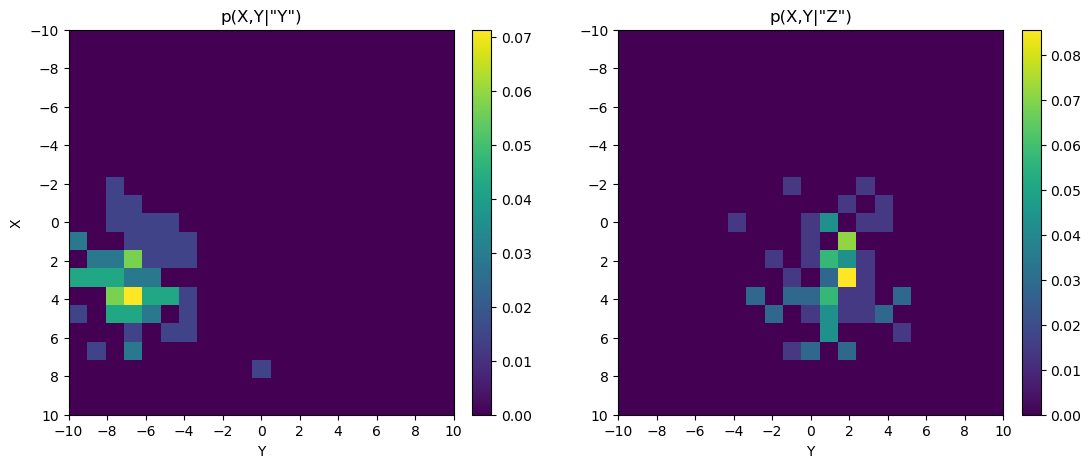

In [3]:
# fill your initials (There are Mirek Dušín and Chuck Norris in the assignment)
letters = "YZ"
D1 = pxy_discrete[letters[0]].copy()
D2 = pxy_discrete[letters[1]].copy()

# plot the distributions
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.imshow(D1, extent=[-10,10,10,-10])
plt.xlabel('Y')
plt.ylabel('X')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('p(X,Y|"' + letters[0] + '")')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.subplot(1, 2, 2)
plt.imshow(D2, extent=[-10,10,10,-10])
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel('Y')
plt.title('p(X,Y|"' + letters[1] + '")')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# plt.savefig('minimax_distributions_discrete.png')

### Optimal strategy

Complete the template of the function `minimax_strategy_discrete`. It should return the optimal Minimax strategy, optimal index $i^*$, and arrays $\epsilon_1$ and $\epsilon_2$ containing the $\epsilon(k)$ errors for all $N+1$ indices $i$.
At positions, where the likelihood ratio is $0/0 = \texttt{nan}$, prefer the first class in the strategy (this is needed for automatic evaluation).

**Hint:** `np.sort` and `np.argsort` handle $\texttt{nan}$ reasonably for the search.

In [4]:
# test
D1_test = np.array([[0.12, 0.06, 0.14], 
                    [0.08, 0.12, 0.18], 
                    [0.04, 0.12, 0.14]])
D2_test = np.array([[0.1,   0.075, 0.175], 
                    [0.175, 0.05,  0.125], 
                    [0.1,   0.025, 0.175]])

q_minimax_discrete, opt_i, eps1, eps2 = minimax_strategy_discrete(D1_test, D2_test)

np.testing.assert_array_equal(q_minimax_discrete, np.array([[0, 1, 1], [1, 0, 0], [1, 0, 1]]), "Found strategy is not correct.")
np.testing.assert_array_almost_equal(eps1, np.array([0.0, 0.04, 0.12, 0.18, 0.32, 0.46, 0.58, 0.76, 0.88, 1.0]), decimal=2, err_msg="Eps1 is incorrect.")
np.testing.assert_array_almost_equal(eps2, np.array([1.0, 0.9, 0.725, 0.65, 0.475, 0.3, 0.2, 0.075, 0.025, 0.0]), decimal=2, err_msg="Eps2 is incorrect.")
np.testing.assert_equal(opt_i, 5, "The i* index is incorrect.")

In [5]:
# the optimal Minimax strategy
q_minimax_discrete, opt_i, eps1, eps2 = minimax_strategy_discrete(D1, D2)

/home/ezvezdov/Programming/RPZ/lab/03_minimax/minimax.py:29: RuntimeWarning: divide by zero encountered in divide
  r = np.divide(distribution1,distribution2)
/home/ezvezdov/Programming/RPZ/lab/03_minimax/minimax.py:29: RuntimeWarning: invalid value encountered in divide
  r = np.divide(distribution1,distribution2)


### Visualization of the strategy

Plot $\epsilon_1$ and $\epsilon_2$ for varying index $i$ together with the found optimal index $i^*$. Use the provided function `plot_lr_threshold`. 

Save the figure to `minimax_lr_search_discrete.png`.

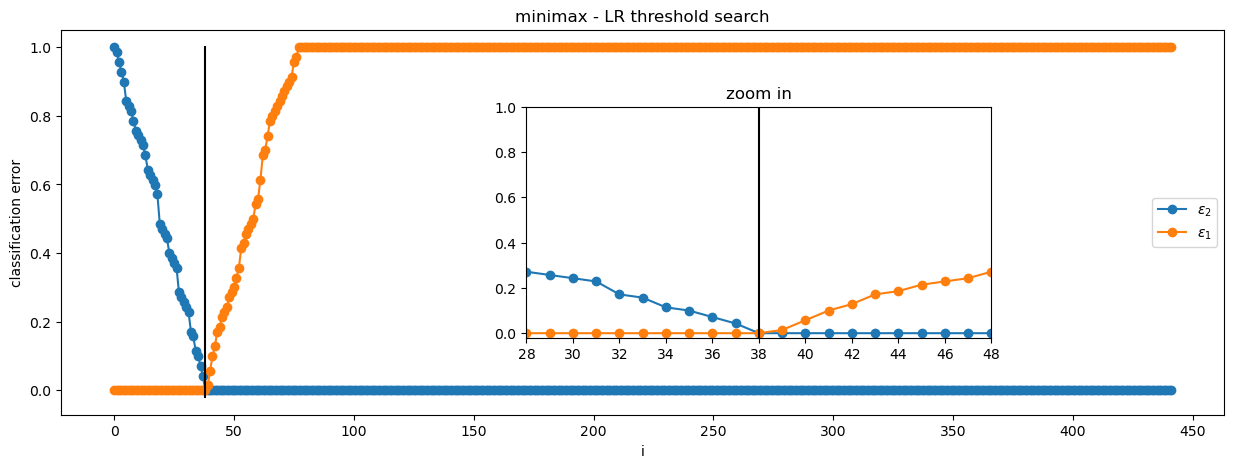

In [6]:
# plot the search for the strategy
plot_lr_threshold(eps1, eps2, opt_i)
plt.savefig('minimax_lr_search_discrete.png')

Plot the found optimal strategy using `plot_discrete_strategy` and save the figure as `minimax_strategy_discrete.png`.

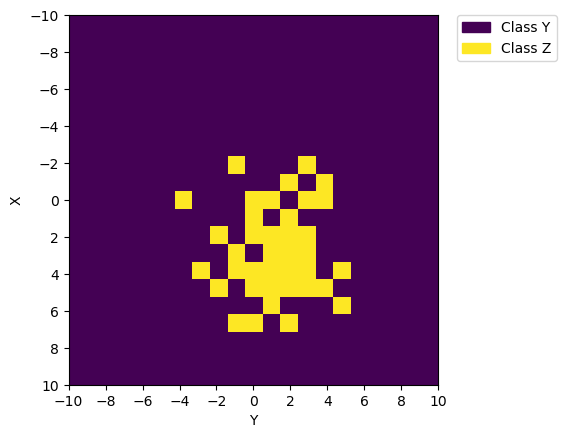

In [7]:
# show the strategy
plot_discrete_strategy(q_minimax_discrete, letters)
plt.savefig('minimax_strategy_discrete.png')

### Classification

Complete the function `classify_discrete` which takes a strategy and a set of image measurements from two classes specified by the `letters` variable and produces the classification labels.

In [8]:
# classification
images_test_2classes, labels_gt = create_test_set(images_tst, labels_tst, letters, alphabet)

labels_estimated_discrete = classify_discrete(images_test_2classes, q_minimax_discrete)

error_discrete = classification_error(labels_estimated_discrete, labels_gt)

### Classification visualization

Show the classification and save the figure as `minimax_classif_discrete.png`.

Error discrete: 30.0000%


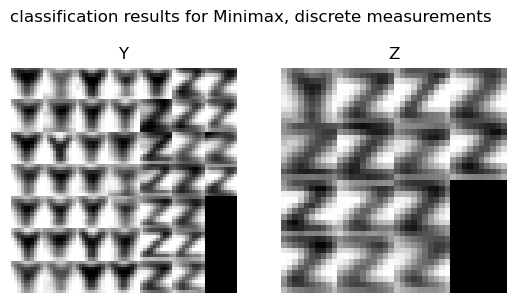

In [9]:
# classification visualisation
show_classification(images_test_2classes, labels_estimated_discrete, letters)
plt.suptitle('classification results for Minimax, discrete measurements', y=0.85)
plt.savefig('minimax_classif_discrete.png')

print(f'Error discrete: {error_discrete*100:.4f}%')

## Part 2: Continuous measurements

In the second part of this lab we will be using a continuous measurement $x\in\mathbb{R}$ computed by `compute_measurement_lr_cont`.

The class probability density functions are assumed to be Normal distributions and they are specified for each letter in the `px_cont[letter]` variable loaded below. So, for instance for the letter "A", the mean is in `px_cont['A']['Mean']` and the standard deviation in `px_cont['A']['Sigma']`.

Again, we will select only two letters (e.g. your initials) from the alphabet and consider only the two-class problem with labels 1 and 2.

### Load data

In [10]:
data = np.load("data_33rpz_03_minimax.npz", allow_pickle=True)
alphabet = data["alphabet"]
images_tst = data["images_test"]
labels_tst = data["labels_test"]
px_cont = data["cont"].item()

In [11]:
# fill e.g. your initials
letters = 'YZ'
D1 = px_cont[letters[0]].copy()
D2 = px_cont[letters[1]].copy()

### Likelihood ratio

From the lecture, we know that the optimal strategy is formed by thresholding likelihood ratio.
So start by deriving the formula for likelihood ratio $r(x) = \frac{p(x|1)}{p(x|2)}$. As specified above, the distributions $p(x|k)$ are Normal distributions with arbitrary mean and standard deviation. The derivation is similar to the one in the Bayes lab.

You should arrive again at a quadratic _equation_, i.e. the likelihood ratio function is parabola-shaped (except for special cases, like in the Bayes assignment - both distribution having the same sigma, etc.).
A given likelihood ratio threshold directly translates to a strategy represented by two measurement thresholds (like in the Bayes assignment).
We can compute the errors $\epsilon(1), \epsilon(2)$ of this strategy and also their maximum $\max \{\epsilon(1), \epsilon(2)\}$.
Finally, we want to find a likelihood ratio threshold, such that the $\max \{\epsilon(1), \epsilon(2)\}$ will be the minimal possible.

Unfortunately there is no close-form solution to this problem for normal distributions and one has to use an iterative numerical procedure (trying different likelihood ratios, for example sped-up by interval halving).

### Relation to Bayes

We are confident that you would be able to implement the above optimization and you may try it if you wish. However, we will explore the relation to the Bayes task instead, which is nicely visible in this particular case.

Let $\lambda$ be a likelihood ratio threshold. Try to simplify $\frac{p(x|1)}{p(x|2)} \geq \lambda$ into a quadratic inequality.

You should arrive at an inequality very similar to the one in Bayes with zero-one loss function. The only difference is that where there was $p_K(2)/p_K(1)$ in Bayes, we do have $\lambda$ instead.
This means that any strategy resulting from likelihood ratio threshold $\lambda$ is a Bayesian strategy for the corresponding prior probabilities $p_K(1) = \frac{1}{1 + \lambda}$, and $p_K(2) = 1 - p_K(1)$.

This is **not a general result**, but it works for two Normal distributions.
Let's study this relation a bit further.

### Bayes risk

Let us visualize the risk of optimal Bayesian strategies as the prior (and thus $\lambda$) changes. Feel free to use the functions you created in the Bayes lab. You will need to copy them to this assignment `minimax.py` so that we can evaluate your solution (imports do not work in BRUTE AE, you really need to copy-paste).

In [12]:
# D1 priors
priors_1 = np.linspace(0,1,101)

# zero one loss function (every error is penalised equally independent of the class)
W = np.array([[0, 1], [1, 0]])

In [13]:
# computing the optimal strategy and its risk for a range of prior probabilities
risk = np.zeros_like(priors_1)
for i in range(priors_1.size):
    D1['Prior'] = float(priors_1[i])
    D2['Prior'] = float(1 - priors_1[i])
    q = find_strategy_2normal(D1, D2)
    risk[i] = bayes_risk_2normal(D1, D2, q)

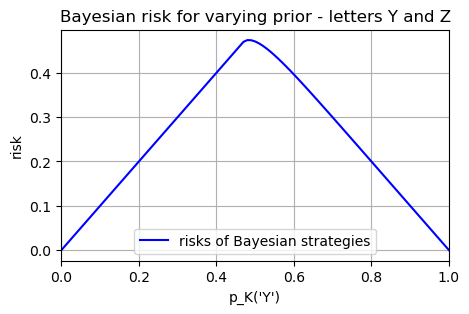

In [14]:
# visualization
plt.figure(figsize=(5,3))
plt.plot(priors_1, risk, 'b')

plt.xlim([0, 1.0])
plt.ylabel('risk')
plt.xlabel(f'p_K(\'{letters[0]}\')')
plt.legend(['risks of Bayesian strategies'])
plt.title(f'Bayesian risk for varying prior - letters {letters[0]} and {letters[1]}')
plt.grid('on')

We may see that there are situations ("crossroads") where it is more difficult to classify the letters correctly and another ones where it is easier.  And indeed we expect to be always correct on a crossroad where only one of the two letters appear (prior 0, prior 1).

### Fixed Bayesian strategy

Let us for a moment assume we did what we are trying to avoid: we built a Bayesian strategy based on data from one crossroad only and applied it everywhere else. We will asume that $p_K(1) = 0.25$ at this particular crossroad.

Complete the function `risk_fix_q_cont` which computes the risk of our fixed strategy over all possible prior probabilities.

Add the fixed strategy risk to the above graph.

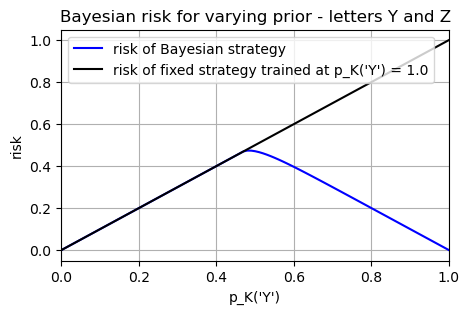

In [15]:
D1['Prior'] = 0.25
D2['Prior'] = 1 - D1['Prior']
q_p1_fix = find_strategy_2normal(D1, D2)
risk_fix = risk_fix_q_cont(D1, D2, priors_1, q_p1_fix)

# visualization
plt.figure(figsize=(5,3))
plt.plot(priors_1, risk, 'b')
plt.plot(priors_1, risk_fix, 'k')

# plt.ylim([0, 1.01])
plt.xlim([0, 1.0])
plt.ylabel('risk')
plt.xlabel(f'p_K(\'{letters[0]}\')')
plt.legend(['risk of Bayesian strategy', f"risk of fixed strategy trained at p_K(\'{letters[0]}\') = {D1['Prior']}"])
plt.title(f'Bayesian risk for varying prior - letters {letters[0]} and {letters[1]}')
plt.grid('on')

You may see that this strategy will never be better than the optimal Bayesian strategy for any other prior probability combination.

What is surprising though is the linear relation of the risk and the prior probability!

### Worst risk of a Bayesian strategy

The linear relation may be surprising, but it can be shown to be valid theoretically:
\begin{align*}
R(q) &= \sum_k \int_{x:q(x)\neq k}p(x,k)dx \\
&= \sum_k p_K(k) \int_{x:q(x)\neq k}p(x|k)dx \\
&= p_K(1) \epsilon_1 + (1 - p_K(1))\epsilon_2 \\
&= p_K(1)(\epsilon_1 - \epsilon_2) + \epsilon_2
\end{align*}
where the first equality is the standard Bayes risk definition with zero-one loss and when going from the second to the third we realize that the integral is actually the error minimized in Minimax.

From this linear relation we may see that every Bayesian strategy will have its worst performance either for $p_K(1) = 0$ or $p_K(1) = 1$ and the value of the risk will be $\epsilon_2$ and $\epsilon_1$ respectively.

And that bring us to **the relation between Bayes and Minimax in this particular case**: In Minimax we are looking for a strategy where $\epsilon_1 = \epsilon_2$. We already know that such strategy will correspond to some Bayesian strategy. In particular, it will correspond to such strategy, for which the fixed strategy experiment results in a horizontal line, i.e. satisfying the condition $\epsilon_1 = \epsilon_2$.

We will use this relation to find the optimal Minimax strategy.

Complete the function `worst_risk_cont`, which for a given prior probability finds the optimal Bayesian strategy and its worst risk. Use the linear relationship discussed above to simplify the search for the worst risk.

Add the plot of the worst risks to the graph we were plotting above.

In [16]:
worst_risk = [worst_risk_cont(D1, D2, float(p)) for p in priors_1]

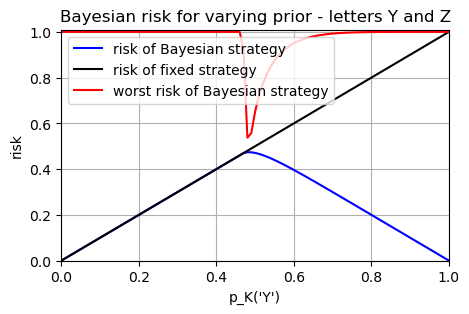

In [17]:
plt.figure(figsize=(5,3))
plt.plot(priors_1, risk, 'b')
plt.plot(priors_1, risk_fix, 'k')
plt.plot(priors_1, worst_risk ,'r')

plt.ylim([0, 1.01])
plt.xlim([0, 1.0])
plt.ylabel('risk')
plt.xlabel(f'p_K(\'{letters[0]}\')')
plt.legend(['risk of Bayesian strategy', 'risk of fixed strategy', 'worst risk of Bayesian strategy'])
plt.title(f'Bayesian risk for varying prior - letters {letters[0]} and {letters[1]}')
plt.grid('on')

In [18]:
# optional interactive plot

def plot_bayesian_risk_for_varying_prior(letters, risk, risk_fix, worst_risk):
    plt.figure(figsize=(5,3))
    plt.plot(priors_1, risk, 'b')
    plt.plot(priors_1, risk_fix, 'k')
    plt.plot(priors_1, worst_risk ,'r')

    plt.ylim([0, 1.01])
    plt.xlim([0, 1.0])
    plt.ylabel('R')
    plt.xlabel('p_K(x)')
    plt.legend(['risk of Bayesian strategy', 'risk of fixed strategy', 'worst risk of Bayesian strategy'])
    plt.title(f'Bayesian risk for varying prior. Letters {letters[0]}, {letters[1]}')
    plt.grid('on')
    

# PyCharm
# %matplotlib notebook
# VSCode
%matplotlib inline
try:
    from ipywidgets import interact, interactive, fixed
    
    @interact(letter1=alphabet, letter2=alphabet, prior1_fixed=(0.,1.,0.01))
    def plot_bayes_cont_interactive(letter1='M', letter2='D', prior1_fixed=0.25):
        D1 = px_cont[letter1]
        D2 = px_cont[letter2]
        letters = letter1 + letter2
        
        risk = np.zeros_like(priors_1)
        for i in range(priors_1.size):
            D1['Prior'] = float(priors_1[i])
            D2['Prior'] = float(1 - priors_1[i])
            q = find_strategy_2normal(D1, D2)
            risk[i] = bayes_risk_2normal(D1, D2, q)
        
        D1['Prior'] = prior1_fixed
        D2['Prior'] = 1 - D1['Prior']
        q_p1_fix = find_strategy_2normal(D1, D2)
        risk_fix = risk_fix_q_cont(D1, D2, priors_1, q_p1_fix)
        worst_risk = [worst_risk_cont(D1, D2, float(p)) for p in priors_1]
        plot_bayesian_risk_for_varying_prior(letters, risk, risk_fix, worst_risk)

except ImportError:
    print('Optional feature.')

interactive(children=(Dropdown(description='letter1', index=10, options=('A', 'B', 'C', 'D', 'E', 'H', 'I', 'J…

### Optimal Minimax strategy

Using the above observations, complete the template function `minmax_strategy_cont`, so that it finds the Minimax strategy and its risk. The optimal Minimax strategy is the Bayesian strategy with minimal maximal risk over all $p_K(1)$ values. Again, there is no close-form solution. Instead, you will iterate over priors (which in fact means iterating over likelihood ratio thresholds as we have derived before) to find the best strategy.
Use `scipy.optimize.fminbound` with a helper function that has just one parameter (the prior) and returns the corresponding worst-case risk (use the `worst_risk_cont` function inside).
The `fminbound` function finds the optimal prior (which can be directly translated to the optimal likelihood threshold) by "iterating" over the priors more intelligently (using interval halving and other techniques).

**Hint:** You wouldn't get enough precision by minimizing over a set of pre-set priors! Check the documentation of `fminbound` to see how to use it for a function minimization.

In [19]:
# unit test
D1_test = px_cont['M']
D2_test = px_cont['D']
q_test, risk_test = minimax_strategy_cont(D1_test, D2_test)
 
np.testing.assert_almost_equal(q_test['t1'], -230.44602069747606, decimal=5)
np.testing.assert_almost_equal(q_test['t2'], 3705.079667023584, decimal=5)
np.testing.assert_array_equal(q_test['decision'], np.array([1, 0, 1], dtype=np.int32))
np.testing.assert_almost_equal(risk_test, 0.2774251160903459, decimal=5)

In [20]:
q_minimax_cont, risk_minimax_cont = minimax_strategy_cont(D1, D2)

print('q: {}'.format(q_minimax_cont))
print('risk: {}'.format(risk_minimax_cont))

q: {'decision': array([1, 0, 1], dtype=int32), 't1': 343.2410771656338, 't2': 1546.3697790353121}
risk: 0.47408896227361086


### Minimax vs Bayes plots

Visualize all the plots in one graph and save the figure as `plots_cont.png`.

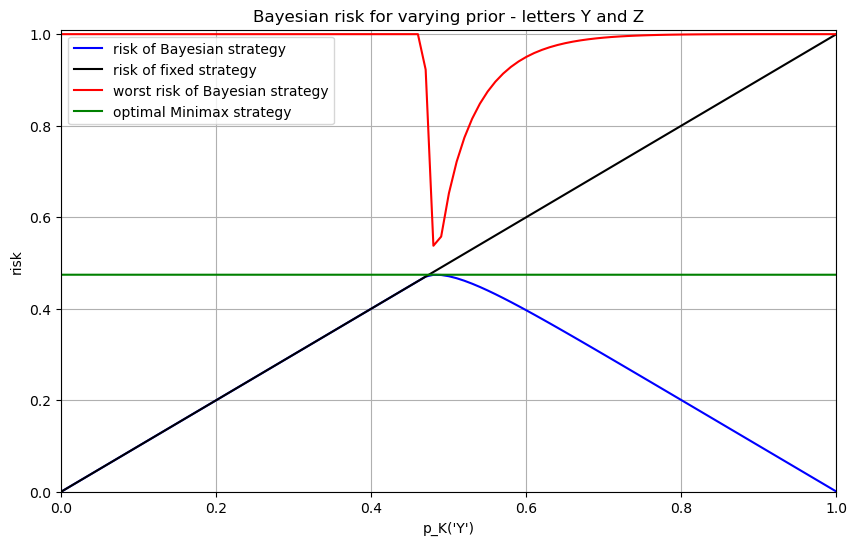

In [21]:
# visualize the found strategy
risk_minimax = risk_fix_q_cont(D1, D2, priors_1, q_minimax_cont)

plt.figure(figsize=(10,6))
plt.plot(priors_1, risk, 'b')
plt.plot(priors_1, risk_fix, 'k')
plt.plot(priors_1, worst_risk ,'r')
plt.plot(priors_1, risk_minimax ,'g')

plt.ylim([0, 1.01])
plt.xlim([0, 1.0])
plt.ylabel('risk')
plt.xlabel(f'p_K(\'{letters[0]}\')')
plt.legend(['risk of Bayesian strategy', 'risk of fixed strategy', 'worst risk of Bayesian strategy', 'optimal Minimax strategy'])
plt.title(f'Bayesian risk for varying prior - letters {letters[0]} and {letters[1]}')
plt.grid('on')
plt.savefig('plots_cont.png')


### Classification

Having the optimal Minimax decision strategy, use it to classify the test images of the same letters. Use the function `create_test_set` to obtain a test set containing only the two required letters. Use your function `classify_2normal` (you need to copy it to `minimax.py`) to classify the dataset and `classification_error` for computing the classification error.

In [22]:

images_test_cont, labels_test_cont = create_test_set(images_tst, labels_tst, letters, alphabet)
measurements_cont = compute_measurement_lr_cont(images_test_cont)
labels_estimated_cont = classify_2normal(measurements_cont, q_minimax_cont)
                                  
error_cont = classification_error(labels_estimated_cont, labels_test_cont)
print(f"Minimax strategy classification error: {error_cont*100:.3}%")

Minimax strategy classification error: 46.7%


Show the final classification for both classes in one figure and save it as `minmax_classif_cont.png`.

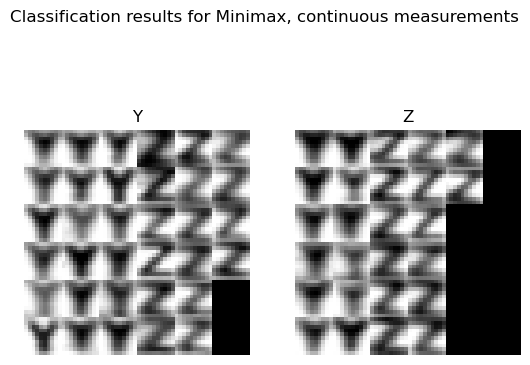

In [23]:
fig = plt.figure()
show_classification(images_test_cont, labels_estimated_cont, letters)
plt.suptitle('Classification results for Minimax, continuous measurements')
plt.savefig('minimax_classif_cont.png')

## Submission to the BRUTE Upload System

To fulfil this assignment, you need to submit these files (all packed in one ''.zip'' file) into the __[upload system](https://cw.felk.cvut.cz/brute/)__:
  - `minimax.ipynb` - a notebook for data initialisation, calling of the implemented functions and plotting of their results (for your convenience, will not be checked).
  - `minimax.py` - file with the following methods implemented:
    - `minimax_strategy_discrete` - function which finds the optimal Minimax strategy for discrete measurements
    - `classify_discrete` - function for using the discrete strategy for image classification
    - `risk_fix_q_cont` - function for computing risk for a fixed strategy but changing a priori probability
    - `worst_risk_cont` - worst case risk for a Bayesian strategy trained with a particular a priori probability but evaluated on all a priori probabilities
    - `minmax_strategy_cont` - function which finds the optimal Minimax strategy for continuous measurements
    - all **necessary functions from the previous assignment (Bayes)** - Unfortunately, including bayes.py and import from it is not supported. You have to copy your functions from `bayes.py` to `minimax.py`.
  - `minimax_lr_search_discrete.png`, `minimax_strategy_discrete.png`, `minimax_classif_discrete.png`, `plots_cont.png` and `minimax_classif_cont.png` - images specified in the tasks
  
When preparing a zip file for the upload system, **do not include any directories**, the files have to be in the zip file root.

## Bonus task

**This task is not compulsory.** 

Go through the chapter on non-Bayesian tasks in SH10 book [2], especially the parts discussing solution of the minimax task by linear programming (pages 25, 31, 35-38, 40-41, 46-47). Solve the above classification task using linear programming as described on page 47. You may ask us for a copy of the relevant pages in case it is difficult for you to borrow the book from a library.

**Hints:**
  - Work with the discrete measurements $x$.
  - Represent the sought strategy (classification function) as a table $\alpha$, with $\alpha(i,k)$ corresponding to the probability of classification of bin 'i' to class 'k' such that $\alpha(i,k) \geq 0$ and $\sum_k \alpha(i,k) = 1$.
  - Reformulate the task in a matrix form according to equation 2.53 in SH10, page 47
  - Solve the task numerically using `scipy.optimize.linprog`.
  - Compare the obtained results with the results of the classification above.

## References

[1] __[Minimax Task](https://cw.fel.cvut.cz/wiki/_media/courses/be5b33rpz/labs/03_minimax/minimax_task.pdf)__ (short support text for labs)

[2] Michail I. Schlesinger, Vaclav Hlavac. Ten Lectures on Statistical and Structural Pattern Recognition. Kluwer Academic Publishers, 2002. (available in CMP library or online)

[3] __[Slides of prof. Matas](http://cmp.felk.cvut.cz/cmp/courses/recognition/slides/non-bayesian_recognition/thumb.html)__